In [122]:
# import pyscfad
# from pyscfad import gto,dft,scf
import matplotlib.pyplot as plt
import equinox as eqx
import pyscf
from pyscf import gto,dft,scf

In [123]:
import numpy as np
import jax.numpy as jnp
import scipy
from ase import Atoms
from ase.io import read
import xcquinox as xce
from functools import partial
from ase.units import Bohr
import os, optax, jax


In [143]:
def get_mol(atoms, basis='6-311++G**'):
    pos = atoms.positions
    spec = atoms.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.Mole(atom=mol_input, basis=atoms.info.get('basis',basis),spin=atoms.info.get('spin',0))
    except Exception:
        mol = gto.Mole(atom=mol_input, basis=atoms.info.get('basis','STO-3G'),spin=atoms.info.get('spin',0))
    return mol 

def get_rhos(rho, spin):
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    if spin != 0:
        rho0_a = rho0[0]
        rho0_b = rho0[1]
        gamma_a, gamma_b = jnp.einsum('ij,ij->j',drho[:,0],drho[:,0]), jnp.einsum('ij,ij->j',drho[:,1],drho[:,1])              
        gamma_ab = jnp.einsum('ij,ij->j',drho[:,0],drho[:,1])
        tau_a, tau_b = tau
    else:
        rho0_a = rho0_b = rho0*0.5
        gamma_a=gamma_b=gamma_ab= jnp.einsum('ij,ij->j',drho[:],drho[:])*0.25
        tau_a = tau_b = tau*0.5
    return rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b
    
def get_data_synth(xc_func, n=100):
    def get_rho(s, a):
        c0 = 2*(3*np.pi**2)**(1/3)
        c1 = 3/10*(3*np.pi**2)**(2/3)
        gamma = c0*s
        tau = c1*a+c0**2*s**2/8
        rho = np.zeros([len(a),6])
        rho[:, 1] = gamma
        rho[:,-1] = tau
        rho[:, 0] = 1
        return rho
    
    s_grid = jnp.concatenate([[0],jnp.exp(jnp.linspace(-10,4,n))])
    rho = []
    for s in s_grid:
        if 'MGGA' in xc_func:
            a_grid = jnp.concatenate([jnp.exp(jnp.linspace(jnp.log((s/100)+1e-8),8,n))])
        else:
            a_grid = jnp.array([0])
        rho.append(get_rho(s, a_grid))
        
    rho = jnp.concatenate(rho)
    
    fxc =  dft.numint.libxc.eval_xc(xc_func,rho.T, spin=0)[0]/dft.numint.libxc.eval_xc('LDA_X',rho.T, spin=0)[0] -1
 
    rho = jnp.asarray(rho)
    
    tdrho = xc.get_descriptors(rho[:,0]/2,rho[:,0]/2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,rho[:,5]/2,rho[:,5]/2, spin_scaling=True)
    


    tFxc = torch.from_numpy(fxc)
    return tdrho[0], tFxc

def get_data(mol, xc_func ,full=False, enhance_spin=False, localnet=None):
    print('mol: ', mol.atom)
    mf = dft.RKS(mol)
    print(mf)   
    mf.xc = 'PBE'
    mf.grids.level = 1
    mf.kernel()
    ao = mf._numint.eval_ao(mol, mf.grids.coords, deriv=2)
    dm = mf.make_rdm1()
    if len(dm.shape) == 2:
        dm = np.array([0.5*dm, 0.5*dm])
    print('ao.shape', ao.shape)
    if not full:
        mf.grids.coords = coords
        mf.grids.weights = weights
    if localnet.spin_scaling:
        print('spin scaling, indicates exchange network')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_alpha,rho_alpha*0), spin=1)[0] -1
        fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_beta*0,rho_beta), spin=1)[0] -1
        print('fxc with xc_func = {} = {}'.format(fxc_a, xc_func))

        if mol.spin != 0 and sum(mol.nelec)>1:
            rho = jnp.concatenate([rho_alpha, rho_beta])
            fxc = jnp.concatenate([fxc_a, fxc_b])
        else:
            rho = rho_alpha
            fxc = fxc_a
    else:    
        print('no spin scaling, indicates correlation network')
        rho_alpha = mf._numint.eval_rho(mol, ao, dm[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, ao, dm[1], xctype='metaGGA',hermi=True)
        exc = mf._numint.eval_xc(xc_func,(rho_alpha,rho_beta), spin=1)[0]
        print('exc with xc_func = {} = {}'.format(exc, xc_func))
        fxc = exc/mf._numint.eval_xc('LDA_C_PW',(rho_alpha, rho_beta), spin=1)[0] -1
        rho = jnp.stack([rho_alpha,rho_beta], axis=-1)
    
    dm = jnp.array(mf.make_rdm1())
    print('get_data, dm shape = {}'.format(dm.shape))
    ao_eval = jnp.array(mf._numint.eval_ao(mol, mf.grids.coords, deriv=1))
    rho = jnp.einsum('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)
    print('rho shape', rho.shape)
    if dm.ndim == 3:
        rho_filt = (jnp.sum(rho[0,0],axis=0) > 1e-6)
    else:
        rho_filt = (rho[0,0] > 1e-6)
    print('rho_filt shape:', rho_filt.shape)

    
    mf.converged=True
    tdrho = xc.get_descriptors(*get_rhos(rho, spin=mol.spin), spin_scaling=localnet.spin_scaling, mf=mf, dm=dm)
    print('tdrho shape from get_descriptors', tdrho.shape)
        
    if localnet.spin_scaling:
        if (mol.spin != 0 and sum(mol.nelec) > 1):
            #tdrho not returned in a spin-polarized form regardless,
            #but the enhancement factors sampled as polarized, so double
            tdrho = jnp.concatenate([tdrho[0],tdrho[1]])
            rho_filt = jnp.concatenate([rho_filt]*2)
        elif sum(mol.nelec) == 1:
            tdrho = tdrho[0]
        else:
            tdrho = tdrho[0]
            
            
    tdrho = tdrho[rho_filt]
    # tdrho = tdrho
    print('tdrho[rho_filt], rho_filt shapes:', tdrho.shape, rho_filt.shape)
    print('fxc shape', fxc.shape)
    tFxc = jnp.array(fxc)[rho_filt]
    # tFxc = jnp.array(fxc)
    print('returned tdrho, tFxc shape: ', tdrho.shape, tFxc.shape)
    return tdrho, tFxc

In [144]:
PRETRAIN_LEVEL = 'MGGA'

TRAIN_NET = 'x'

REFERENCE_XC = 'PBE0'

N_HIDDEN = 16
DEPTH = 3
if PRETRAIN_LEVEL == 'GGA':
    if TRAIN_NET == 'x':
        localx = xce.net.eX(n_input=1, n_hidden=N_HIDDEN, use=[1], depth=DEPTH, lob=1.804)
    elif TRAIN_NET == 'c':
        localc = xce.net.eC(n_input=3, n_hidden=N_HIDDEN, use=[2], depth=DEPTH, ueg_limit=True)
elif PRETRAIN_LEVEL == 'MGGA':
    if TRAIN_NET == 'x':
        localx = xce.net.eX(n_input=2, n_hidden=N_HIDDEN, use=[1, 2], depth=DEPTH, ueg_limit=True, lob=1.174)
    elif TRAIN_NET == 'c':
        localc = xce.net.eC(n_input=4, n_hidden=N_HIDDEN, depth=DEPTH, use=[2,3], ueg_limit=True)
elif PRETRAIN_LEVEL == 'NONLOCAL':
    if TRAIN_NET == 'x':
        localx = xce.net.eX(n_input=18, n_hidden=N_HIDDEN, depth=DEPTH, ueg_limit=True, lob=1.174)
    elif TRAIN_NET == 'c':
        #n_input = 4 from base, 12 from NL
        localc = xce.net.eC(n_input=16, n_hidden=N_HIDDEN, depth=DEPTH, ueg_limit=True)

if TRAIN_NET == 'x':
    thislocal = localx
else:
    thislocal = localc
ueg = xce.xc.LDA_X()
xc = xce.xc.eXC(grid_models=[thislocal], heg_mult=True, level= {'GGA':2, 'MGGA':3, 'NONLOCAL':4}[PRETRAIN_LEVEL])

In [145]:
spins = {
    'Al': 1,
    'B' : 1,
    'Li': 1,
    'Na': 1,
    'Si': 2 ,
    'Be':0,
    'C': 2,
    'Cl': 1,
    'F': 1,
    'H': 1,
    'N': 3,
    'O': 2,
    'P': 3,
    'S': 2
}

selection = [2, 113, 25, 18, 11, 17, 114, 121, 101, 0, 20, 26, 29, 67, 28, 110, 125, 10, 115, 89, 105, 50]
try:
    atoms = [read('/home/awills/Documents/Research/ogdpyscf/dpyscf/data/haunschild_g2/g2_97.traj',':')[s] for s in selection]
except:
    atoms = [read('/home/awills/Documents/Research/ogdpyscf/data/haunschild_g2/g2_97.traj',':')[s] for s in selection]
ksr_atoms = atoms
if PRETRAIN_LEVEL=='MGGA':
    ksr_atoms = ksr_atoms[2:]
ksr_atoms = [Atoms('P',info={'spin':3}), Atoms('N', info={'spin':3}), Atoms('H', info={'spin':1}),Atoms('Li', info={'spin':1}), Atoms('O',info={'spin':2}),Atoms('Cl',info={'spin':1}),Atoms('Al',info={'spin':1}), Atoms('S',info={'spin':2})] + ksr_atoms
# ksr_atoms = [Atoms('H',info={'spin':1})]
mols = [get_mol(atoms) for atoms in ksr_atoms]
mols = [i for i in mols if len(i.atom) < 8]
for i in mols:
    print(i, i.atom, len(i.atom))

<pyscf.gto.mole.Mole object at 0x7f362c6a8bb0> [['P', array([0., 0., 0.])]] 1
<pyscf.gto.mole.Mole object at 0x7f364ea0d9c0> [['N', array([0., 0., 0.])]] 1
<pyscf.gto.mole.Mole object at 0x7f364ea0e200> [['H', array([0., 0., 0.])]] 1
<pyscf.gto.mole.Mole object at 0x7f364ea0e6b0> [['Li', array([0., 0., 0.])]] 1
<pyscf.gto.mole.Mole object at 0x7f364ea0d6f0> [['O', array([0., 0., 0.])]] 1
<pyscf.gto.mole.Mole object at 0x7f364ea0ebc0> [['Cl', array([0., 0., 0.])]] 1
<pyscf.gto.mole.Mole object at 0x7f37f8144af0> [['Al', array([0., 0., 0.])]] 1
<pyscf.gto.mole.Mole object at 0x7f37f8146740> [['S', array([0., 0., 0.])]] 1
<pyscf.gto.mole.Mole object at 0x7f37f8147c10> [['Li', array([ 0.      ,  0.      , -1.172697])], ['F', array([0.      , 0.      , 0.390899])]] 2
<pyscf.gto.mole.Mole object at 0x7f37f81478b0> [['C', array([ 0.      ,  0.      , -0.499686])], ['N', array([0.      , 0.      , 0.652056])], ['H', array([ 0.        ,  0.        , -1.56627401])]] 3
<pyscf.gto.mole.Mole object

In [146]:
# data = [get_data(mol, xc_func=ref, full=i<14) for i,mol in enumerate(mols)]
ref = 'PBE0'
data = [get_data(mol, xc_func=ref,full=True, localnet=thislocal) for i,mol in enumerate(mols)]
# 
# data = [get_data_synth(ref, 100)]
tdrho = jnp.concatenate([d[0] for d in data])
tFxc = jnp.concatenate([d[1] for d in data])

mol:  [['P', array([0., 0., 0.])]]
ROKS object of <class 'pyscf.dft.roks.ROKS'>


Initialize <pyscf.gto.mole.Mole object at 0x7f362c6a8bb0> in ROKS object of <class 'pyscf.dft.roks.ROKS'>


converged SCF energy = -341.103975305829
ao.shape (10, 6320, 30)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35227731  0.35296584  0.33914136 ... -0.24267484 -0.24267484
 -0.24267484] = PBE0
get_data, dm shape = (2, 30, 30)
rho shape (4, 4, 2, 6320)
rho_filt shape: (6320,)
tdrho shape from get_descriptors (2, 6320, 3)
tdrho[rho_filt], rho_filt shapes: (10940, 3) (12640,)
fxc shape (12640,)
returned tdrho, tFxc shape:  (10940, 3) (10940,)
mol:  [['N', array([0., 0., 0.])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f364ea0d9c0> in ROKS object of <class 'pyscf.dft.roks.ROKS'>


ROKS object of <class 'pyscf.dft.roks.ROKS'>
converged SCF energy = -54.5278183883328
ao.shape (10, 5184, 22)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35208183  0.35288518  0.35299592 ... -0.2364243  -0.2364243
 -0.2364243 ] = PBE0
get_data, dm shape = (2, 22, 22)
rho shape (4, 4, 2, 5184)
rho_filt shape: (5184,)
tdrho shape from get_descriptors (2, 5184, 3)
tdrho[rho_filt], rho_filt shapes: (8668, 3) (10368,)
fxc shape (10368,)
returned tdrho, tFxc shape:  (8668, 3) (8668,)
mol:  [['H', array([0., 0., 0.])]]


/tmp/ipykernel_403777/450337447.py:82: RuntimeWarning: invalid value encountered in divide
  fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_beta*0,rho_beta), spin=1)[0] -1
Initialize <pyscf.gto.mole.Mole object at 0x7f364ea0e200> in ROKS object of <class 'pyscf.dft.roks.ROKS'>


ROKS object of <class 'pyscf.dft.roks.ROKS'>
converged SCF energy = -0.499812984023536
ao.shape (10, 2488, 7)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35187063  0.35279876  0.35299579 ... -0.19767117 -0.19767117
 -0.19767117] = PBE0
get_data, dm shape = (2, 7, 7)
rho shape (4, 4, 2, 2488)
rho_filt shape: (2488,)
tdrho shape from get_descriptors (2, 2488, 3)
tdrho[rho_filt], rho_filt shapes: (2144, 3) (2488,)
fxc shape (2488,)
returned tdrho, tFxc shape:  (2144, 3) (2144,)
mol:  [['Li', array([0., 0., 0.])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f364ea0e6b0> in ROKS object of <class 'pyscf.dft.roks.ROKS'>


ROKS object of <class 'pyscf.dft.roks.ROKS'>
converged SCF energy = -7.46006139980432
ao.shape (10, 4640, 22)
spin scaling, indicates exchange network
fxc with xc_func = [0.34328499 0.3516925  0.3516925  ... 0.3516925  0.2854847  0.32157416] = PBE0
get_data, dm shape = (2, 22, 22)
rho shape (4, 4, 2, 4640)
rho_filt shape: (4640,)
tdrho shape from get_descriptors (2, 4640, 3)
tdrho[rho_filt], rho_filt shapes: (8600, 3) (9280,)
fxc shape (9280,)
returned tdrho, tFxc shape:  (8600, 3) (8600,)
mol:  [['O', array([0., 0., 0.])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f364ea0d6f0> in ROKS object of <class 'pyscf.dft.roks.ROKS'>


ROKS object of <class 'pyscf.dft.roks.ROKS'>
SCF not converged.
SCF energy = -74.9982140194554
ao.shape (10, 5208, 22)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35287239  0.35299136  0.35299989 ... -0.23777472 -0.23777472
 -0.23777472] = PBE0
get_data, dm shape = (2, 22, 22)
rho shape (4, 4, 2, 5208)
rho_filt shape: (5208,)
tdrho shape from get_descriptors (2, 5208, 3)
tdrho[rho_filt], rho_filt shapes: (8576, 3) (10416,)
fxc shape (10416,)
returned tdrho, tFxc shape:  (8576, 3) (8576,)
mol:  [['Cl', array([0., 0., 0.])]]


/tmp/ipykernel_403777/450337447.py:81: RuntimeWarning: invalid value encountered in divide
  fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_alpha,rho_alpha*0), spin=1)[0] -1
Initialize <pyscf.gto.mole.Mole object at 0x7f364ea0ebc0> in ROKS object of <class 'pyscf.dft.roks.ROKS'>


ROKS object of <class 'pyscf.dft.roks.ROKS'>
SCF not converged.
SCF energy = -459.953886030314
ao.shape (10, 6320, 30)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35270316  0.35211859  0.35291892 ... -0.2433945  -0.2433945
 -0.2433945 ] = PBE0
get_data, dm shape = (2, 30, 30)
rho shape (4, 4, 2, 6320)
rho_filt shape: (6320,)
tdrho shape from get_descriptors (2, 6320, 3)
tdrho[rho_filt], rho_filt shapes: (10600, 3) (12640,)
fxc shape (12640,)
returned tdrho, tFxc shape:  (10600, 3) (10600,)
mol:  [['Al', array([0., 0., 0.])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f37f8144af0> in ROKS object of <class 'pyscf.dft.roks.ROKS'>


ROKS object of <class 'pyscf.dft.roks.ROKS'>
converged SCF energy = -242.22588978536
ao.shape (10, 6088, 30)
spin scaling, indicates exchange network
fxc with xc_func = [0.31326259 0.33538426 0.34803383 ... 0.35298092 0.35244062 0.35298943] = PBE0
get_data, dm shape = (2, 30, 30)
rho shape (4, 4, 2, 6088)
rho_filt shape: (6088,)
tdrho shape from get_descriptors (2, 6088, 3)
tdrho[rho_filt], rho_filt shapes: (11152, 3) (12176,)
fxc shape (12176,)
returned tdrho, tFxc shape:  (11152, 3) (11152,)
mol:  [['S', array([0., 0., 0.])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f37f8146740> in ROKS object of <class 'pyscf.dft.roks.ROKS'>


ROKS object of <class 'pyscf.dft.roks.ROKS'>
SCF not converged.
SCF energy = -397.934909282881
ao.shape (10, 6320, 30)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35290158  0.35283183  0.35207235 ... -0.24305675 -0.24305675
 -0.24305675] = PBE0
get_data, dm shape = (2, 30, 30)
rho shape (4, 4, 2, 6320)
rho_filt shape: (6320,)
tdrho shape from get_descriptors (2, 6320, 3)
tdrho[rho_filt], rho_filt shapes: (10940, 3) (12640,)
fxc shape (12640,)
returned tdrho, tFxc shape:  (10940, 3) (10940,)
mol:  [['Li', array([ 0.      ,  0.      , -1.172697])], ['F', array([0.      , 0.      , 0.390899])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f37f8147c10> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -107.339357395734
ao.shape (10, 9752, 44)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.34473895  0.3513519   0.34617638 ...  0.3387902  -0.19613777
 -0.19613777] = PBE0
get_data, dm shape = (44, 44)
rho shape (4, 4, 9752)
rho_filt shape: (9752,)
tdrho shape from get_descriptors (2, 9752, 3)
tdrho[rho_filt], rho_filt shapes: (8409, 3) (9752,)
fxc shape (9752,)
returned tdrho, tFxc shape:  (8409, 3) (8409,)
mol:  [['C', array([ 0.      ,  0.      , -0.499686])], ['N', array([0.      , 0.      , 0.652056])], ['H', array([ 0.        ,  0.        , -1.56627401])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f37f81478b0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -93.3377924465542
ao.shape (10, 12264, 51)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35292632  0.35299817  0.35299745 ... -0.19589931 -0.19589931
 -0.19589931] = PBE0
get_data, dm shape = (51, 51)
rho shape (4, 4, 12264)
rho_filt shape: (12264,)
tdrho shape from get_descriptors (2, 12264, 3)
tdrho[rho_filt], rho_filt shapes: (10779, 3) (12264,)
fxc shape (12264,)
returned tdrho, tFxc shape:  (10779, 3) (10779,)
mol:  [['C', array([0., 0., 0.])], ['O', array([0.      , 0.      , 1.162879])], ['O', array([ 0.      ,  0.      , -1.162879])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f37f8146f50> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -188.456965322842
ao.shape (10, 14920, 66)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35295559  0.35296945  0.35273511 ...  0.35299994 -0.23465037
 -0.23465037] = PBE0
get_data, dm shape = (66, 66)
rho shape (4, 4, 14920)
rho_filt shape: (14920,)
tdrho shape from get_descriptors (2, 14920, 3)
tdrho[rho_filt], rho_filt shapes: (13014, 3) (14920,)
fxc shape (14920,)
returned tdrho, tFxc shape:  (13014, 3) (13014,)
mol:  [['Cl', array([0.      , 0.      , 1.008241])], ['Cl', array([ 0.      ,  0.      , -1.008241])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f37f8146a70> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -920.005608888958
ao.shape (10, 12208, 60)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.3504011   0.35254329  0.33578573 ...  0.35254329 -0.18020569
 -0.18020569] = PBE0
get_data, dm shape = (60, 60)
rho shape (4, 4, 12208)
rho_filt shape: (12208,)
tdrho shape from get_descriptors (2, 12208, 3)
tdrho[rho_filt], rho_filt shapes: (10764, 3) (12208,)
fxc shape (12208,)
returned tdrho, tFxc shape:  (10764, 3) (10764,)
mol:  [['F', array([0.      , 0.      , 0.693963])], ['F', array([ 0.      ,  0.      , -0.693963])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f36342ee2c0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -199.394370591176
ao.shape (10, 9824, 44)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35298653  0.35299954  0.35277789 ... -0.18909525 -0.18909525
 -0.18909525] = PBE0
get_data, dm shape = (44, 44)
rho shape (4, 4, 9824)
rho_filt shape: (9824,)
tdrho shape from get_descriptors (2, 9824, 3)
tdrho[rho_filt], rho_filt shapes: (8654, 3) (9824,)
fxc shape (9824,)
returned tdrho, tFxc shape:  (8654, 3) (8654,)
mol:  [['O', array([0.      , 0.      , 0.603195])], ['O', array([ 0.      ,  0.      , -0.603195])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f364c0fb3d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
SCF not converged.
SCF energy = -150.165645507711
ao.shape (10, 9912, 44)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35288616  0.35299209  0.35299989 ... -0.19659511 -0.19659511
 -0.19659511] = PBE0
get_data, dm shape = (44, 44)
rho shape (4, 4, 9912)
rho_filt shape: (9912,)
tdrho shape from get_descriptors (2, 9912, 3)
tdrho[rho_filt], rho_filt shapes: (8570, 3) (9912,)
fxc shape (9912,)
returned tdrho, tFxc shape:  (8570, 3) (8570,)
mol:  [['C', array([0.      , 0.      , 0.599454])], ['C', array([ 0.      ,  0.      , -0.599454])], ['H', array([ 0.        ,  0.        , -1.66162301])], ['H', array([0.        , 0.        , 1.66162301])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f364c0fafb0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -77.2435048344973
ao.shape (10, 14440, 58)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35292956  0.35299783  0.352997   ... -0.19345783 -0.19345783
 -0.19345783] = PBE0
get_data, dm shape = (58, 58)
rho shape (4, 4, 14440)
rho_filt shape: (14440,)
tdrho shape from get_descriptors (2, 14440, 3)
tdrho[rho_filt], rho_filt shapes: (12990, 3) (14440,)
fxc shape (14440,)
returned tdrho, tFxc shape:  (12990, 3) (12990,)
mol:  [['O', array([0.      , 0.      , 0.484676])], ['C', array([ 0.      ,  0.      , -0.646235])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f364c0fafe0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -113.221335689669
ao.shape (10, 10048, 44)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35286355  0.35271162  0.35137181 ... -0.20056513 -0.20056513
 -0.20056513] = PBE0
get_data, dm shape = (44, 44)
rho shape (4, 4, 10048)
rho_filt shape: (10048,)
tdrho shape from get_descriptors (2, 10048, 3)
tdrho[rho_filt], rho_filt shapes: (8780, 3) (10048,)
fxc shape (10048,)
returned tdrho, tFxc shape:  (8780, 3) (8780,)
mol:  [['Cl', array([0.      , 0.      , 0.071315])], ['H', array([ 0.      ,  0.      , -1.212358])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f381017d1b0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -460.624592374077
ao.shape (10, 8552, 37)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.3529419   0.35299895  0.35299845 ... -0.16753441 -0.16753441
 -0.16753441] = PBE0
get_data, dm shape = (37, 37)
rho shape (4, 4, 8552)
rho_filt shape: (8552,)
tdrho shape from get_descriptors (2, 8552, 3)
tdrho[rho_filt], rho_filt shapes: (7377, 3) (8552,)
fxc shape (8552,)
returned tdrho, tFxc shape:  (7377, 3) (7377,)
mol:  [['Li', array([0.      , 0.      , 0.403632])], ['H', array([ 0.      ,  0.      , -1.210897])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f381017cc10> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -8.04458854018923
ao.shape (10, 6936, 29)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35077081  0.35076405  0.35076405 ... -0.04591371 -0.04591371
 -0.04591371] = PBE0
get_data, dm shape = (29, 29)
rho shape (4, 4, 6936)
rho_filt shape: (6936,)
tdrho shape from get_descriptors (2, 6936, 3)
tdrho[rho_filt], rho_filt shapes: (6179, 3) (6936,)
fxc shape (6936,)
returned tdrho, tFxc shape:  (6179, 3) (6179,)
mol:  [['Na', array([0.        , 0.        , 1.50747901])], ['Na', array([ 0.        ,  0.        , -1.50747901])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f381017f8b0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -324.340512506579
ao.shape (10, 11536, 60)
spin scaling, indicates exchange network
fxc with xc_func = [0.34882401 0.34882401 0.34640539 ... 0.34882401 0.34882401 0.34640539] = PBE0
get_data, dm shape = (60, 60)
rho shape (4, 4, 11536)
rho_filt shape: (11536,)
tdrho shape from get_descriptors (2, 11536, 3)
tdrho[rho_filt], rho_filt shapes: (10980, 3) (11536,)
fxc shape (11536,)
returned tdrho, tFxc shape:  (10980, 3) (10980,)
mol:  [['Al', array([0., 0., 0.])], ['Cl', array([0.        , 2.08019101, 0.        ])], ['Cl', array([ 1.80149801, -1.040095  ,  0.        ])], ['Cl', array([-1.80149801, -1.040095  ,  0.        ])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f381017fca0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -1622.57507845817
ao.shape (10, 24504, 120)
spin scaling, indicates exchange network
fxc with xc_func = [0.35297281 0.35284645 0.32767437 ... 0.35299547 0.35297605 0.35298261] = PBE0
get_data, dm shape = (120, 120)
rho shape (4, 4, 24504)
rho_filt shape: (24504,)
tdrho shape from get_descriptors (2, 24504, 3)
tdrho[rho_filt], rho_filt shapes: (22010, 3) (24504,)
fxc shape (24504,)
returned tdrho, tFxc shape:  (22010, 3) (22010,)
mol:  [['P', array([0.      , 0.      , 0.128906])], ['H', array([ 0.      ,  1.19333 , -0.644531])], ['H', array([ 1.033455, -0.596665, -0.644531])], ['H', array([-1.033455, -0.596665, -0.644531])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f381017f0a0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -342.979728469579
ao.shape (10, 13088, 51)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35047299  0.35284585  0.3529969  ... -0.22054072 -0.22054072
 -0.22054072] = PBE0
get_data, dm shape = (51, 51)
rho shape (4, 4, 13088)
rho_filt shape: (13088,)
tdrho shape from get_descriptors (2, 13088, 3)
tdrho[rho_filt], rho_filt shapes: (11831, 3) (13088,)
fxc shape (13088,)
returned tdrho, tFxc shape:  (11831, 3) (11831,)
mol:  [['Si', array([0.      , 0.      , 1.135214])], ['Si', array([ 0.      ,  0.      , -1.135214])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f381017c370> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
SCF not converged.
SCF energy = -578.541406963769
ao.shape (10, 12384, 60)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35297724  0.35295178  0.35295185 ... -0.1747555  -0.1747555
 -0.1747555 ] = PBE0
get_data, dm shape = (60, 60)
rho shape (4, 4, 12384)
rho_filt shape: (12384,)
tdrho shape from get_descriptors (2, 12384, 3)
tdrho[rho_filt], rho_filt shapes: (11319, 3) (12384,)
fxc shape (12384,)
returned tdrho, tFxc shape:  (11319, 3) (11319,)
mol:  [['C', array([0., 0., 0.])], ['H', array([0.630382, 0.630382, 0.630382])], ['H', array([-0.630382, -0.630382,  0.630382])], ['H', array([ 0.630382, -0.630382, -0.630382])], ['H', array([-0.630382,  0.630382, -0.630382])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f381017de70> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -40.4598214864008
ao.shape (10, 13936, 50)
spin scaling, indicates exchange network
fxc with xc_func = [0.352642   0.35294844 0.35299903 ... 0.35299824 0.35299824 0.35299824] = PBE0
get_data, dm shape = (50, 50)
rho shape (4, 4, 13936)
rho_filt shape: (13936,)
tdrho shape from get_descriptors (2, 13936, 3)
tdrho[rho_filt], rho_filt shapes: (12616, 3) (13936,)
fxc shape (13936,)
returned tdrho, tFxc shape:  (12616, 3) (12616,)
mol:  [['C', array([0.      , 0.      , 0.179918])], ['H', array([ 0.      ,  0.855475, -0.539754])], ['H', array([ 0.      , -0.855475, -0.539754])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f363443d2d0> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -39.0756147483525
ao.shape (10, 9656, 36)
spin scaling, indicates exchange network
fxc with xc_func = [ 0.35266567  0.35299597  0.35296276 ... -0.08131804 -0.08131804
 -0.08131804] = PBE0
get_data, dm shape = (36, 36)
rho shape (4, 4, 9656)
rho_filt shape: (9656,)
tdrho shape from get_descriptors (2, 9656, 3)
tdrho[rho_filt], rho_filt shapes: (8643, 3) (9656,)
fxc shape (9656,)
returned tdrho, tFxc shape:  (8643, 3) (8643,)
mol:  [['Si', array([0., 0., 0.])], ['H', array([0.855876, 0.855876, 0.855876])], ['H', array([-0.855876, -0.855876,  0.855876])], ['H', array([-0.855876,  0.855876, -0.855876])], ['H', array([ 0.855876, -0.855876, -0.855876])]]


Initialize <pyscf.gto.mole.Mole object at 0x7f363443cb50> in RKS object of <class 'pyscf.dft.rks.RKS'>


RKS object of <class 'pyscf.dft.rks.RKS'>
converged SCF energy = -291.719272437817
ao.shape (10, 15256, 58)
spin scaling, indicates exchange network
fxc with xc_func = [0.35267139 0.35295005 0.35299895 ... 0.35299876 0.35299876 0.35299876] = PBE0
get_data, dm shape = (58, 58)
rho shape (4, 4, 15256)
rho_filt shape: (15256,)
tdrho shape from get_descriptors (2, 15256, 3)
tdrho[rho_filt], rho_filt shapes: (13972, 3) (15256,)
fxc shape (15256,)
returned tdrho, tFxc shape:  (13972, 3) (13972,)


In [147]:
nan_filt = ~jnp.any((tdrho != tdrho),axis=-1)

tFxc = tFxc[nan_filt]
tdrho = tdrho[nan_filt,:]

In [148]:
tdrho[::].shape, tdrho[::], tFxc.shape, tFxc

((258507, 3),
 Array([[-3.32705354,  2.23826797,  1.3976115 ],
        [-3.81214229,  2.88661268,  1.74487365],
        [-2.97702168,  1.8062523 ,  1.01744669],
        ...,
        [-4.21483075,  3.09331731,  0.54065516],
        [-4.2551875 ,  3.15236019,  0.27690273],
        [-4.31527657,  3.09061936,  1.35860903]], dtype=float64),
 (258507,),
 Array([0.32321715, 0.34550121, 0.27866855, ..., 0.3483771 , 0.3489568 ,
        0.34849784], dtype=float64))

In [155]:
cpus = jax.devices(backend='cpu')

In [157]:
first_pred = jax.vmap(thislocal.net)(tdrho[...,thislocal.use])

In [158]:
PRINT_EVERY=200
scheduler = optax.exponential_decay(init_value = 1e-2, transition_begin=50, transition_steps=500, decay_rate=0.9)
# optimizer = optax.adam(learning_rate = 1e-2)
optimizer = optax.adam(learning_rate = scheduler)

class PT_E_Loss():

    def __call__(self, model, inp, ref):

        pred = jax.vmap(model.net)(inp)[:, 0]

        err = pred-ref

        return jnp.mean(jnp.square(err))

trainer = xce.train.xcTrainer(model=thislocal, optim=optimizer, steps=500, loss = PT_E_Loss(), do_jit=True)
if TRAIN_NET == 'x':
    inp = [tdrho[..., trainer.model.use]]
else:
    inp = [tdrho]
with jax.default_device(cpus[0]):
    newm = trainer(1, trainer.model, inp, [tFxc])
        

# for epoch in range(100000):
#     total_loss = 0
#     results = thislocal(tdrho[::])
#     loss = eloss(results, tFxc[::])
#     total_loss += loss.item()
#     loss.backward()

#     optimizer.step()
#     optimizer.zero_grad()
#     if epoch%PRINT_EVERY==0:
#         print('total loss {:.12f}'.format(total_loss))
        


Epoch 0
Epoch 0 :: Batch 0/1
Batch Loss = 0.04258258292795655
0, epoch_train_loss=0.04258258292795655
Epoch 1
Epoch 1 :: Batch 0/1
Batch Loss = 0.032519359746718025
1, epoch_train_loss=0.032519359746718025
Epoch 2
Epoch 2 :: Batch 0/1
Batch Loss = 0.024238569149181446
2, epoch_train_loss=0.024238569149181446
Epoch 3
Epoch 3 :: Batch 0/1
Batch Loss = 0.017086910064990683
3, epoch_train_loss=0.017086910064990683
Epoch 4
Epoch 4 :: Batch 0/1
Batch Loss = 0.012138335542539437
4, epoch_train_loss=0.012138335542539437
Epoch 5
Epoch 5 :: Batch 0/1
Batch Loss = 0.010357628202600114
5, epoch_train_loss=0.010357628202600114
Epoch 6
Epoch 6 :: Batch 0/1
Batch Loss = 0.008737039299116714
6, epoch_train_loss=0.008737039299116714
Epoch 7
Epoch 7 :: Batch 0/1
Batch Loss = 0.008578859616133604
7, epoch_train_loss=0.008578859616133604
Epoch 8
Epoch 8 :: Batch 0/1
Batch Loss = 0.008955227566997428
8, epoch_train_loss=0.008955227566997428
Epoch 9
Epoch 9 :: Batch 0/1
Batch Loss = 0.007738658601652393
9, 

Exception ignored in: <function _TemporaryFileCloser.__del__ at 0x7f38fc02feb0>
Traceback (most recent call last):
  File "/home/awills/anaconda3/envs/pyscfad/lib/python3.10/tempfile.py", line 466, in __del__
    self.close()
  File "/home/awills/anaconda3/envs/pyscfad/lib/python3.10/tempfile.py", line 462, in close
    unlink(self.name)
FileNotFoundError: [Errno 2] No such file or directory: '/home/awills/Documents/Research/xcquinox/notebooks/tmp3zh_9ibi'


Batch Loss = 0.0021667281823983843
31, epoch_train_loss=0.0021667281823983843
Epoch 32
Epoch 32 :: Batch 0/1
Batch Loss = 0.001990851612246215
32, epoch_train_loss=0.001990851612246215
Epoch 33
Epoch 33 :: Batch 0/1
Batch Loss = 0.0018742574752281466
33, epoch_train_loss=0.0018742574752281466
Epoch 34
Epoch 34 :: Batch 0/1
Batch Loss = 0.0018495660637195372
34, epoch_train_loss=0.0018495660637195372
Epoch 35
Epoch 35 :: Batch 0/1
Batch Loss = 0.001908689417896073
35, epoch_train_loss=0.001908689417896073
Epoch 36
Epoch 36 :: Batch 0/1
Batch Loss = 0.001975951688999165
36, epoch_train_loss=0.001975951688999165
Epoch 37
Epoch 37 :: Batch 0/1
Batch Loss = 0.001960672293542873
37, epoch_train_loss=0.001960672293542873
Epoch 38
Epoch 38 :: Batch 0/1
Batch Loss = 0.0018776017709180102
38, epoch_train_loss=0.0018776017709180102
Epoch 39
Epoch 39 :: Batch 0/1
Batch Loss = 0.0018017199542181023
39, epoch_train_loss=0.0018017199542181023
Epoch 40
Epoch 40 :: Batch 0/1
Batch Loss = 0.001765471148

In [159]:
best_pred = jax.vmap(newm.net)(tdrho[...,newm.use])[:, 0]

0.03701143915827484


Text(0.5, 0, 'Gridpoint Index')

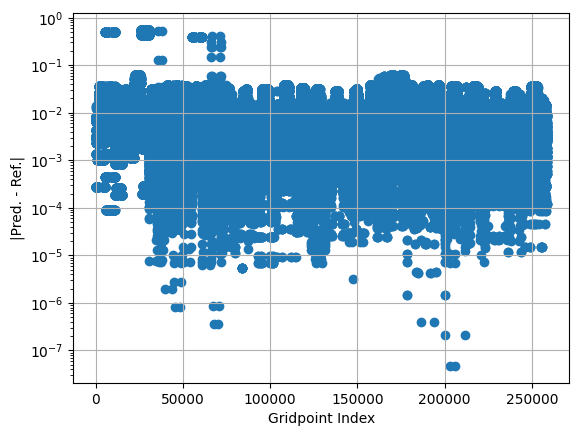

In [160]:
f = plt.figure()
ax = f.add_subplot(111)
sel = 1
xs = np.arange(0, len(best_pred[::sel]))
ax.grid()
ax.scatter(xs, abs(best_pred[::sel]-tFxc[::sel]))
# ax.scatter(best_pred[::sel], tFxc[::sel])
rmse = np.sqrt( np.mean( (best_pred[::sel] - tFxc[::sel])**2))
print(rmse)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 10)
ax.set_yscale('log')
ax.set_ylabel('|Pred. - Ref.|')
ax.set_xlabel('Gridpoint Index')

0.20635547709706314


Text(0.5, 0, 'Gridpoint Index')

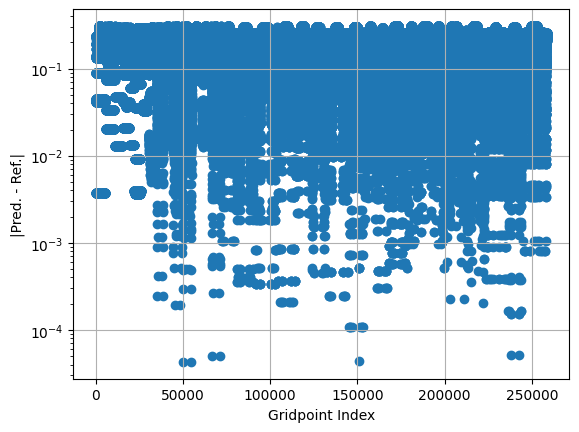

In [161]:
f = plt.figure()
ax = f.add_subplot(111)
sel = 1
xs = np.arange(0, len(first_pred[::sel]))
ax.grid()
ax.scatter(xs, abs(first_pred.T[0][::sel]-tFxc[::sel]))
rmse = np.sqrt( np.mean( (first_pred.T[0][::sel] - tFxc[::sel])**2))
print(rmse)
# ax.set_xlim(0, 1)
# ax.set_ylim(-1, 1000)
ax.set_yscale('log')
ax.set_ylabel('|Pred. - Ref.|')
ax.set_xlabel('Gridpoint Index')


Below for nonlocal, not specifically shaped MGGA

In [150]:
first_pred = jax.vmap(thislocal.net)(tdrho)

TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (3,).

In [26]:
first_pred.shape

(271330, 1)

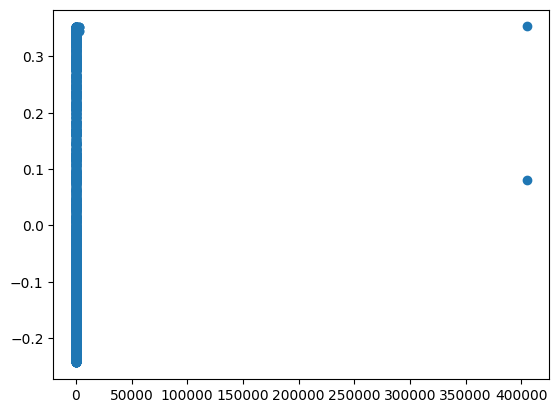

In [28]:
plt.scatter(first_pred[::100], tFxc[::100])

(0.0, 10.0)

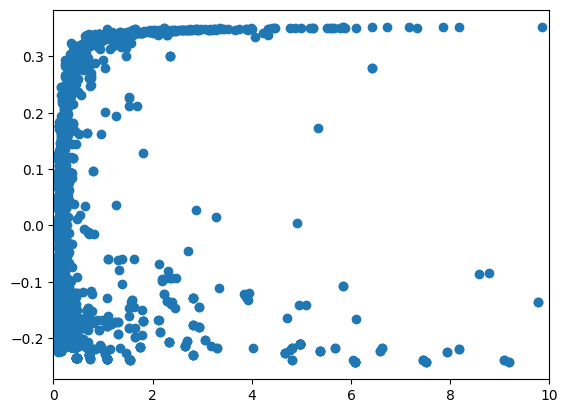

In [34]:
f = plt.figure()
ax = f.add_subplot(111)

ax.scatter(first_pred[::100], tFxc[::100])
ax.set_xlim(0, 10)

In [36]:
PRINT_EVERY=200
scheduler = optax.exponential_decay(init_value = 1e-2, transition_begin=50, transition_steps=500, decay_rate=0.9)
# optimizer = optax.adam(learning_rate = 1e-2)
optimizer = optax.adam(learning_rate = scheduler)

class PT_E_Loss():

    def __call__(self, model, inp, ref):

        pred = jax.vmap(model.net)(inp)[:, 0]

        err = pred-ref

        return jnp.mean(jnp.square(err))

trainer = xce.train.xcTrainer(model=thislocal, optim=optimizer, steps=500, loss = PT_E_Loss(), do_jit=True)
if TRAIN_NET == 'x':
    inp = [tdrho[:, trainer.model.use]]
else:
    inp = [tdrho]
with jax.default_device(cpus[0]):
    newm = trainer(1, trainer.model, inp, [tFxc])
        

# for epoch in range(100000):
#     total_loss = 0
#     results = thislocal(tdrho[::])
#     loss = eloss(results, tFxc[::])
#     total_loss += loss.item()
#     loss.backward()

#     optimizer.step()
#     optimizer.zero_grad()
#     if epoch%PRINT_EVERY==0:
#         print('total loss {:.12f}'.format(total_loss))
        


Epoch 0
Epoch 0 :: Batch 0/1
Batch Loss = 234645634.95129338
0, epoch_train_loss=234645634.95129338
Epoch 1
Epoch 1 :: Batch 0/1
Batch Loss = 784930448.0832758
1, epoch_train_loss=784930448.0832758
Epoch 2
Epoch 2 :: Batch 0/1
Batch Loss = 122474897.785456
2, epoch_train_loss=122474897.785456
Epoch 3
Epoch 3 :: Batch 0/1
Batch Loss = 35335861.831510946
3, epoch_train_loss=35335861.831510946
Epoch 4
Epoch 4 :: Batch 0/1
Batch Loss = 187728223.03193584
4, epoch_train_loss=187728223.03193584
Epoch 5
Epoch 5 :: Batch 0/1
Batch Loss = 175026633.5080138
5, epoch_train_loss=175026633.5080138
Epoch 6
Epoch 6 :: Batch 0/1
Batch Loss = 74262084.89777067
6, epoch_train_loss=74262084.89777067
Epoch 7
Epoch 7 :: Batch 0/1
Batch Loss = 9120801.918356905
7, epoch_train_loss=9120801.918356905
Epoch 8
Epoch 8 :: Batch 0/1
Batch Loss = 4454531.429033055
8, epoch_train_loss=4454531.429033055
Epoch 9
Epoch 9 :: Batch 0/1
Batch Loss = 26414460.42400402
9, epoch_train_loss=26414460.42400402
Epoch 10
Epoch 1

In [55]:
new_pred = jax.vmap(newm.net)(tdrho).T[0]

In [75]:
chkpts = sorted([i for i in os.listdir() if 'xc.eqx' in i], key=lambda x: int(x.split('.')[-1]))

In [87]:
chkpts[-1]

'xc.eqx.414'

In [90]:
bestnet = eqx.tree_deserialise_leaves(chkpts[-2], newm)

In [91]:
best_pred = jax.vmap(bestnet.net)(tdrho)[:, 0]

0.19670672636023315


Text(0.5, 0, 'Gridpoint Index')

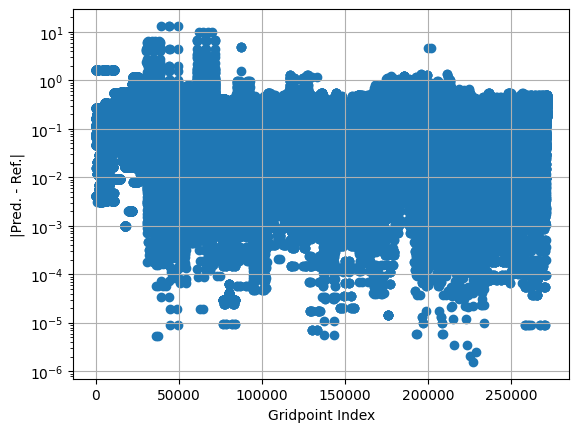

In [119]:
f = plt.figure()
ax = f.add_subplot(111)
sel = 1
xs = np.arange(0, len(best_pred[::sel]))
ax.grid()
ax.scatter(xs, abs(best_pred[::sel]-tFxc[::sel]))
# ax.scatter(best_pred[::sel], tFxc[::sel])
rmse = np.sqrt( np.mean( (best_pred[::sel] - tFxc[::sel])**2))
print(rmse)

# ax.set_xlim(0, 1)
# ax.set_ylim(0, 10)
ax.set_yscale('log')
ax.set_ylabel('|Pred. - Ref.|')
ax.set_xlabel('Gridpoint Index')


0.5309857588302664


(-1.0, 1.0)

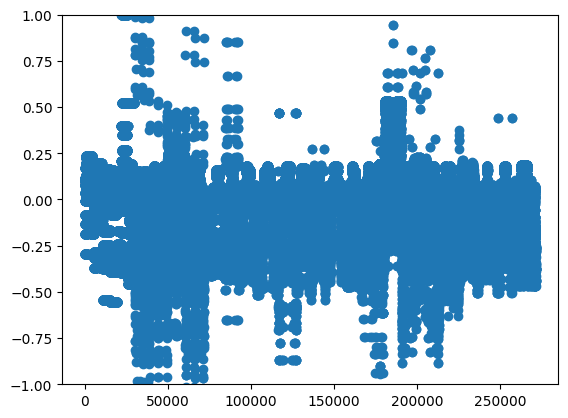

In [103]:
f = plt.figure()
ax = f.add_subplot(111)
sel = 1
xs = np.arange(0, len(new_pred[::sel]))

ax.scatter(xs, new_pred[::sel]-tFxc[::sel])
rmse = np.sqrt( np.mean( (new_pred[::sel] - tFxc[::sel])**2))
print(rmse)

# ax.set_xlim(0, 1)
ax.set_ylim(-1, 1)

15318.14724277363


Text(0.5, 0, 'Gridpoint Index')

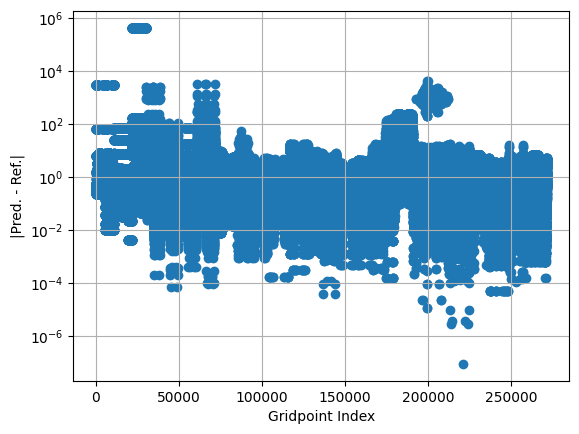

In [121]:
f = plt.figure()
ax = f.add_subplot(111)
sel = 1
xs = np.arange(0, len(first_pred[::sel]))
ax.grid()
ax.scatter(xs, abs(first_pred.T[0][::sel]-tFxc[::sel]))
rmse = np.sqrt( np.mean( (first_pred.T[0][::sel] - tFxc[::sel])**2))
print(rmse)
# ax.set_xlim(0, 1)
# ax.set_ylim(-1, 1000)
ax.set_yscale('log')
ax.set_ylabel('|Pred. - Ref.|')
ax.set_xlabel('Gridpoint Index')


In [65]:
first_pred.shape

(271330, 1)

In [59]:
xs.shape, (new_pred[::sel]-tFxc[::sel]).shape

((2714,), (2714,))

In [61]:

new_pred.shape, tFxc.shape

((271330,), (271330,))